In [14]:
import spacy

nlp = spacy.load("fr_core_news_lg")

In [ ]:
from pathlib import Path

import pandas as pd

DATA_FOLDER = Path(".") / "data"
PARTIES = list(DATA_FOLDER.glob("*.csv"))

dataset = pd.concat([pd.read_csv(party) for party in PARTIES]).reset_index(drop=True)

# The decision was made to aggregate all tweets of users to obtain a large corpus
# per user instead of invidivual tweets, which don't embed much political signal.
dataset = (
    dataset
        .drop_duplicates(subset=["tweet", "user_id"], keep="last")
        .groupby(["user_id", "account"])
        .agg({'tweet': ' '.join})
        .rename(columns={"tweet": "tweets"})
        .reset_index()
)
dataset

In [16]:
import string
import re

import numpy as np

from spacy.lang.fr.stop_words import STOP_WORDS

def tokenize(tweet):
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()).lower()
    tokens = [token.lemma_ for token in nlp(text) if token.vector.any()]

    return ' '.join([
        t for t in tokens
        if t not in STOP_WORDS
        and t not in string.punctuation
        and not t.isdigit() 
        and len(t) > 3
    ])


embeddings = np.array([t.vector for t in nlp.pipe(dataset["tweets"].apply(tokenize))])
embeddings

array([[ 0.81675094,  0.42881992, -1.8611046 , ...,  0.42110822,
        -0.05564046, -0.5352255 ],
       [ 0.3147003 , -0.08204787, -1.561677  , ..., -0.03699923,
        -0.19976771,  0.13432203],
       [ 0.7346399 , -0.19910626, -1.8716512 , ..., -0.36482486,
        -0.10303842, -0.45169568],
       ...,
       [ 0.85319805, -0.43733454, -1.602534  , ..., -0.1473145 ,
        -0.18544912, -0.40974268],
       [ 0.81076217, -0.28029513, -2.0759184 , ..., -0.29834822,
         0.19500813, -0.29423192],
       [ 0.59651434,  0.10915355, -1.3988367 , ..., -0.23575792,
         0.05624746, -0.1530168 ]], dtype=float32)

In [17]:
from sklearn.manifold import TSNE

t_sne = TSNE(n_components=2, init='random').fit_transform(embeddings)

docs_2d = pd.DataFrame(t_sne, columns=["x", "y"])
docs_2d["category"] = dataset["account"].astype("category")
docs_2d

,x,y,category
0,16.208569,8.484970,lesRepublicains
1,-9.630800,13.717241,lesRepublicains
2,-4.786583,4.801019,FranceInsoumise
3,14.694625,7.541962,FranceInsoumise
4,-0.616100,-15.577777,FranceInsoumise
...,...,...,...
627,-8.687977,-7.284590,FranceInsoumise
628,6.652781,2.586993,FranceInsoumise
629,-7.129631,11.067340,FranceInsoumise
630,-4.030815,0.839390,FranceInsoumise


<AxesSubplot: xlabel='x', ylabel='y'>

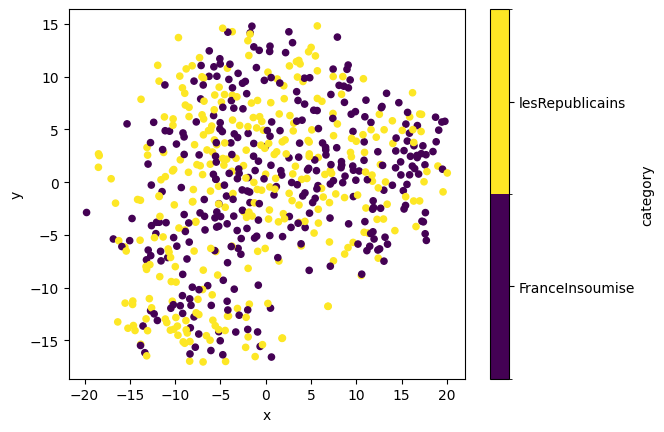

In [18]:
docs_2d.plot.scatter(x="x", y="y", c="category", colormap="viridis")

<AxesSubplot: xlabel='x', ylabel='y'>

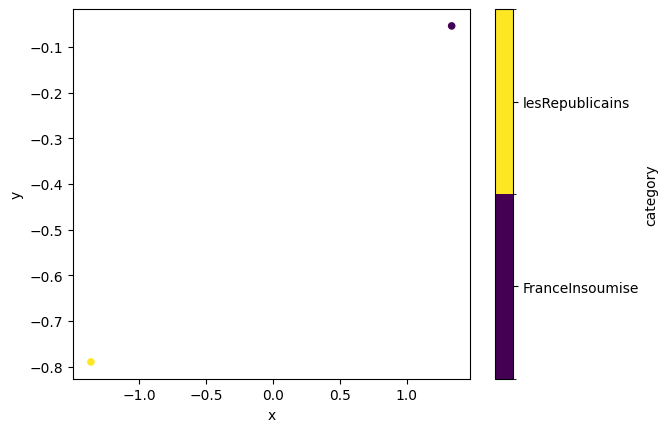

In [19]:
centroids = docs_2d.groupby('category').mean()
centroids["category"] = centroids.index
centroids.plot.scatter(x="x", y="y", c="category", colormap="viridis")

In [20]:
train_set = dataset.sample(frac=.8)
test_set = dataset.drop(train_set.index)

train_X, test_X = embeddings[train_set.index], embeddings[test_set.index]
train_y, test_y = train_set["account"], test_set["account"]

In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5).fit(train_X, train_y)

In [ ]:
def exp_predict(index_to_predict):
    row = dataset.iloc[index_to_predict]
    print(f"Predicting user, expected account: {row['account']}")

    to_predict = test_X[index_to_predict].reshape(1, -1)
    predicted = knn.predict(to_predict)
    print(f"Predicted {predicted[0]}")

    nearest_neighbors = knn.kneighbors(to_predict)
    for distance, ind in zip(nearest_neighbors[0][0], nearest_neighbors[1][0]):
        nearest = dataset.iloc[ind]
        print(f"nearest includes: '{nearest['user_id']}' with a distance of {distance}, whose account was: '{nearest['account']}'\n")


exp_predict(test_y.index[0])

In [23]:
from sklearn.metrics import accuracy_score

pred_y = knn.predict(test_X)

accuracy_score(test_y, pred_y)

0.5476190476190477

<AxesSubplot: >

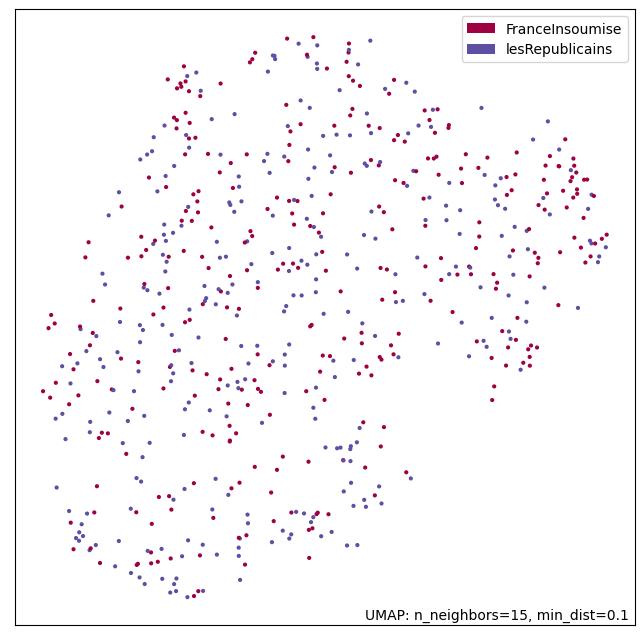

In [30]:
import umap.umap_ as umap
import umap.plot

doc_2d = umap.UMAP(n_components=2).fit(embeddings)
umap.plot.points(doc_2d, labels=dataset["account"])